## DS 410 Final Project

Importing libraries, Creating Spark Session, and Reading in the Dataset

In [1]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.sql.functions import lower
from pyspark.sql.types import StructField, StructType, StringType, LongType, IntegerType, FloatType
from pyspark.sql.functions import col, column
from pyspark.sql.functions import expr
from pyspark.sql.functions import split
from pyspark.sql import Row

import pandas as pd
import matplotlib.pyplot as plt

/storage/home/lfm5648/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/home/lfm5648/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
ss=SparkSession.builder.master("local").appName("Midterm_Examination").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/16 11:42:46 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
ss.sparkContext.setCheckpointDir("~/scratch")

In [4]:
schema = StructType([StructField("Sentiment", IntegerType(), nullable = False), \
                     StructField("Title", StringType(), nullable = False), \
                     StructField("Text", StringType(), nullable = False)
                    ])

In [5]:
reviews1 = ss.read.csv("/storage/work/lfm5648/Final_Project/Amazon_reviews_sample.csv", schema = schema, header = True, inferSchema = False)

In [6]:
reviews = reviews1.na.drop()

In [7]:
reviews.printSchema()

root
 |-- Sentiment: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Text: string (nullable = true)



In [8]:
reviews.show(5)

+---------+--------------------+--------------------+
|Sentiment|               Title|                Text|
+---------+--------------------+--------------------+
|        1|Sorry I wasted my...|Neil Gaiman wrote...|
|        1|Loved the prose, ...|Rabbit was not a ...|
|        2|         FASCINATING|Am a Jack Higgins...|
|        1|Little Annie Fann...|This was very, ve...|
|        2|     pressing matter|I have owned Rowe...|
+---------+--------------------+--------------------+
only showing top 5 rows


## EDA

## Distribution of Review Sentiment

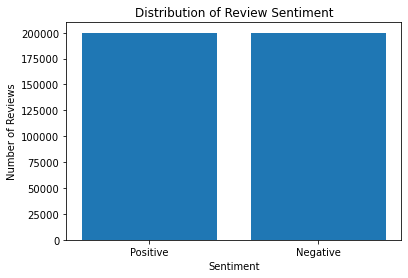

In [9]:
reviews_label = reviews.withColumn("Labeled Sentiment", when(reviews["Sentiment"] == 2, "Positive").when(reviews["Sentiment"] == 1, "Negative"))
sentiment_counts = reviews_label.groupBy("Labeled Sentiment").count()
pandas_sentiment=sentiment_counts.toPandas()
plt.bar(pandas_sentiment["Labeled Sentiment"],pandas_sentiment["count"])
plt.title("Distribution of Review Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

Removing special characters

In [10]:
from pyspark.sql.functions import regexp_replace
reviews_special_title = reviews_label.withColumn("Title", regexp_replace("Title", "[^a-zA-Z0-9\\s]", ""))
reviews_only_text = reviews_special_title.withColumn("Text", regexp_replace("Text", "[^a-zA-Z0-9\\s]", ""))

Making all words lowercase and splitting by space

In [11]:
reviews_split_title = reviews_label.withColumn("Title", split(lower(reviews_label["Title"]), " "))
reviews_split_title_text = reviews_split_title.withColumn("Text", split(lower(reviews_split_title["Text"]), " "))

Removing stop words, making rdd of title of reviews and text of reviews for positive and negative sentiment

In [12]:
from pyspark.ml.feature import StopWordsRemover
remover = StopWordsRemover(inputCols=["Title", "Text"], outputCols=["Title (No Stop Words)", "Text (No Stop Words)"])
reviews_no_stop_words = remover.transform(reviews_split_title_text)
reviews_title_flat_pos = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Positive").select("Title (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_text_flat_pos = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Positive").select("Text (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_title_flat_neg = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Negative").select("Title (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)
reviews_text_flat_neg = reviews_no_stop_words.filter(reviews_no_stop_words["Labeled Sentiment"] == "Negative").select("Text (No Stop Words)").rdd.flatMap(lambda x: x).flatMap(lambda x: x)

Concatenate title and reviews rdd for positive and negative sentiment

In [13]:
reviews_pos = reviews_title_flat_pos.union(reviews_text_flat_pos)
reviews_neg = reviews_title_flat_neg.union(reviews_text_flat_neg)

Map words to key-value pairs ex. (word, 1)

In [14]:
reviews_pos_key_val = reviews_pos.map(lambda x: (x, 1))
reviews_neg_key_val = reviews_neg.map(lambda x: (x, 1))

Reduce key-value pairs by key (aggregate counts of words)

In [15]:
reviews_pos_key_val_reduced = reviews_pos_key_val.reduceByKey(lambda x, y: x + y, 4)
reviews_neg_key_val_reduced = reviews_neg_key_val.reduceByKey(lambda x, y: x + y, 4)

Sort aggregated counts of words in descending order

In [16]:
reviews_pos_key_val_sorted = reviews_pos_key_val_reduced.sortBy(lambda pair: pair[1], ascending=False)
reviews_neg_key_val_sorted = reviews_neg_key_val_reduced.sortBy(lambda pair: pair[1], ascending=False)

Get ten most frequent words for title of reviews and text of reviews

In [17]:
reviews_pos_key_val_sorted_top_ten = reviews_pos_key_val_sorted.take(10)
reviews_neg_key_val_sorted_top_ten  = reviews_neg_key_val_sorted.take(10)

## Bar graph of ten most frequent words in positive reviews

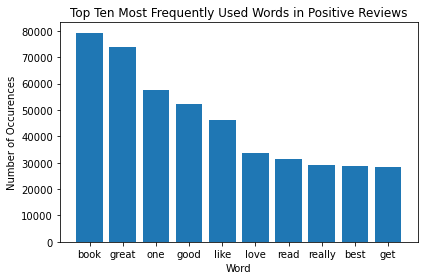

In [18]:
plt.bar([item[0] for item in reviews_pos_key_val_sorted_top_ten], [item[1] for item in reviews_pos_key_val_sorted_top_ten])
plt.xlabel("Word")
plt.ylabel("Number of Occurences")
plt.title("Top Ten Most Frequently Used Words in Positive Reviews")
plt.tight_layout()
plt.show()

## Bar graph of ten most frequent words in negative reviews

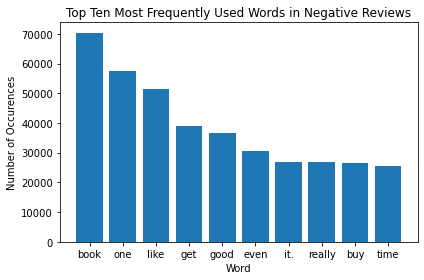

In [19]:
plt.bar([item[0] for item in reviews_neg_key_val_sorted_top_ten], [item[1] for item in reviews_neg_key_val_sorted_top_ten])
plt.xlabel("Word")
plt.ylabel("Number of Occurences")
plt.title("Top Ten Most Frequently Used Words in Negative Reviews")
plt.tight_layout()
plt.show()